### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os
pd.set_option('display.max_rows', 16)

### Locate raw experiment CSV files

In [2]:
# Set the data directory, list the experiment CSVs, and add a helper to extract the user id from each filename.
from pathlib import Path

data_dir = Path("data")
csv_files = sorted(data_dir.glob("*_experiment.csv"))


def extract_userid(path: Path) -> int:
    parts = path.stem.split("_")
    try:
        return int(parts[2])
    except (IndexError, ValueError) as exc:
        raise ValueError(f"Unexpected filename format: {path.name}") from exc

pd.DataFrame({"file": [p.name for p in csv_files], "userid": [extract_userid(p) for p in csv_files]})

,file,userid
0,20251217_104912_47931_experiment.csv,47931
1,20251217_110617_54965_experiment.csv,54965
2,20251217_111631_40644_experiment.csv,40644
3,20251217_113228_59864_experiment.csv,59864
4,20251217_114106_50568_experiment.csv,50568
5,20251225_164323_91494_experiment.csv,91494
6,20251225_165742_90524_experiment.csv,90524
7,20251225_170459_53092_experiment.csv,53092
8,20251225_171313_46184_experiment.csv,46184
9,20260104_154722_98241_experiment.csv,98241


### Load all trials (use raw observations)


In [3]:
# For each CSV, attach userid to every row, retain optional per-user summary, and create a long table of all observations.

conditions = ["None", "Sound", "Haptics", "Both"]

all_trials = []

rows = []



for csv_path in csv_files:

    df = pd.read_csv(csv_path, keep_default_na=False)

    user_id = extract_userid(csv_path)

    df["userid"] = user_id

    all_trials.append(df)



    summary = (

        df.groupby("Condition", as_index=True)

        .agg(

            mean_time=("Time", "mean"),

            pattern=("SequenceName", "first"),

            score=("RatingForCondition", "first"),

        )

    )



    row = {"userid": user_id}

    for cond in conditions:

        if cond in summary.index:

            row[cond] = round(summary.loc[cond, "mean_time"], 4)

            row[f"{cond}Pattern"] = summary.loc[cond, "pattern"]

            row[f"{cond}Score"] = summary.loc[cond, "score"]

        else:

            row[cond] = pd.NA

            row[f"{cond}Pattern"] = pd.NA

            row[f"{cond}Score"] = pd.NA



    rows.append(row)



all_trials_df = (

    pd.concat(all_trials, ignore_index=True)

    .assign(Condition=lambda df_: df_["Condition"].astype("category"))

)



user_summary = pd.DataFrame(rows).sort_values("userid").reset_index(drop=True)

output_path = data_dir / "condition_summary_by_user.csv"

user_summary.to_csv(output_path, index=False)



display(pd.DataFrame({"file": [p.name for p in csv_files], "userid": [extract_userid(p) for p in csv_files]}))

print(f"Loaded {len(all_trials_df)} total trials across {len(user_summary)} users.")


,file,userid
0,20251217_104912_47931_experiment.csv,47931
1,20251217_110617_54965_experiment.csv,54965
2,20251217_111631_40644_experiment.csv,40644
3,20251217_113228_59864_experiment.csv,59864
4,20251217_114106_50568_experiment.csv,50568
5,20251225_164323_91494_experiment.csv,91494
6,20251225_165742_90524_experiment.csv,90524
7,20251225_170459_53092_experiment.csv,53092
8,20251225_171313_46184_experiment.csv,46184
9,20260104_154722_98241_experiment.csv,98241


Loaded 600 total trials across 10 users.


### Condition-level descriptives from all trials


In [4]:
condition_stats = (

    all_trials_df.groupby("Condition")["Time"]

    .agg(mean="mean", median="median", std="std", count="count")

    .sort_index()

)



print("Condition-level statistics (using every trial):")

display(condition_stats.round(4))

display(all_trials_df)


Condition-level statistics (using every trial):


C:\Users\Tiago\AppData\Local\Temp\ipykernel_8352\3888194583.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_trials_df.groupby("Condition")["Time"]


,mean,median,std,count
Condition,,,,
Both,1.8121,1.7400,0.6658,150
Haptics,1.9307,1.9355,0.8467,150
None,1.9879,1.7175,1.2720,150
Sound,2.0578,1.9185,0.8469,150


,PhaseOrder,Condition,SequenceName,Round,Time,RatingForCondition,userid
0,1,None,PatternC,1,6.794,1,47931
1,1,None,PatternC,2,3.690,1,47931
2,1,None,PatternC,3,1.447,1,47931
3,1,None,PatternC,4,1.072,1,47931
4,1,None,PatternC,5,1.958,1,47931
...,...,...,...,...,...,...,...
595,4,None,PatternA,11,2.019,3,98241
596,4,None,PatternA,12,0.696,3,98241
597,4,None,PatternA,13,1.545,3,98241
598,4,None,PatternA,14,1.030,3,98241


### Visualizations

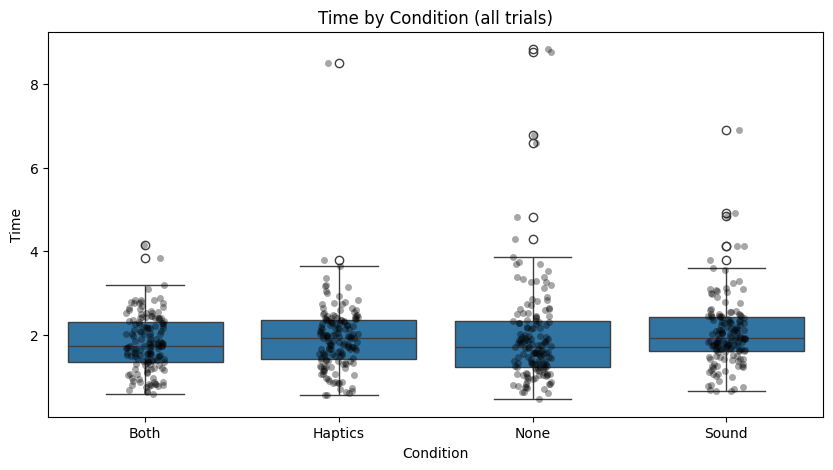

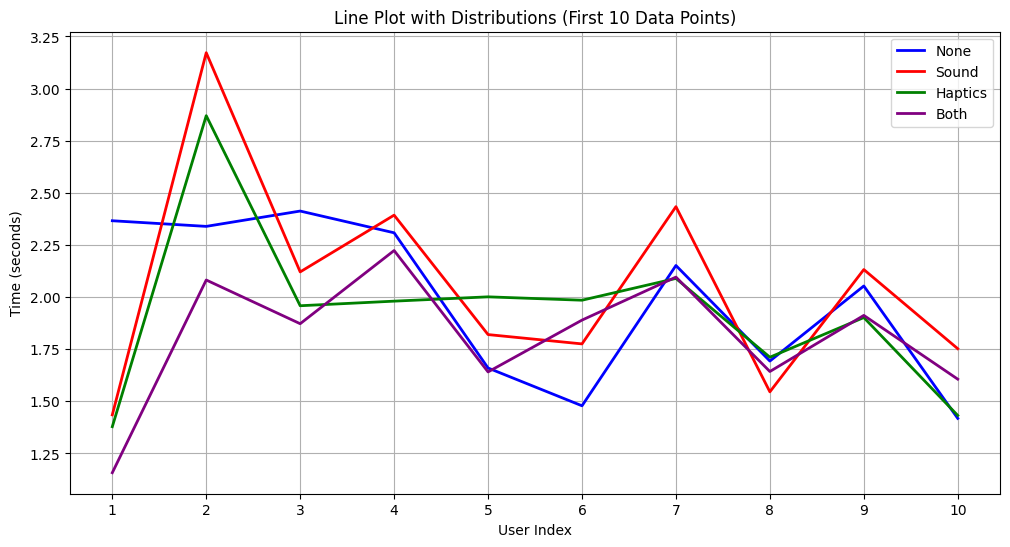

In [5]:
plt.figure(figsize=(10, 5))

sns.boxplot(data=all_trials_df, x="Condition", y="Time")

sns.stripplot(data=all_trials_df, x="Condition", y="Time", color="black", alpha=0.35, jitter=True)

plt.title("Time by Condition (all trials)")

plt.xlabel("Condition")

plt.ylabel("Time")

plt.show()


datapoints = 10
x_data = np.arange(1, datapoints+1) # Corresponds to R's 1:datapoints+1

if len(user_summary) >= datapoints:
    plt.figure(figsize=(12, 6))
    plt.plot(x_data, user_summary['None'].iloc[:datapoints], label='None', color='blue', linewidth=2)
    plt.plot(x_data, user_summary['Sound'].iloc[:datapoints], label='Sound', color='red', linewidth=2)
    plt.plot(x_data, user_summary['Haptics'].iloc[:datapoints], label='Haptics', color='green', linewidth=2)
    plt.plot(x_data, user_summary['Both'].iloc[:datapoints], label='Both', color='purple', linewidth=2)
    plt.title('Line Plot with Distributions (First 10 Data Points)')
    plt.xlabel('User Index')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, datapoints + 1, 1))
    plt.show()

else:
    print("Not enough data points (less than 10) in 'user_summary' for the intended line plot.")


### Simple Statistics

In [6]:
print("\nPer-condition time summary:")

display(all_trials_df.groupby("Condition")["Time"].describe())



for cond in conditions:

    cond_vals = all_trials_df.loc[all_trials_df["Condition"] == cond, "Time"].dropna()

    shapiro_res = stats.shapiro(cond_vals)

    print(

        f"Shapiro-Wilk for {cond}: Statistic={shapiro_res.statistic:.4f}, p-value={shapiro_res.pvalue:.16f} (n={len(cond_vals)})"

    )
    
print()
    
for pat in all_trials_df["SequenceName"].unique():

    cond_vals = all_trials_df.loc[all_trials_df["SequenceName"] == pat, "Time"].dropna()

    shapiro_res = stats.shapiro(cond_vals)

    print(

        f"Shapiro-Wilk for {pat}: Statistic={shapiro_res.statistic:.4f}, p-value={shapiro_res.pvalue:.16f} (n={len(cond_vals)})"

    )



Per-condition time summary:


C:\Users\Tiago\AppData\Local\Temp\ipykernel_8352\3080258466.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(all_trials_df.groupby("Condition")["Time"].describe())


,count,mean,std,min,25%,50%,75%,max
Condition,,,,,,,,
Both,150.0,1.81214,0.665814,0.584,1.35350,1.7400,2.31500,4.163
Haptics,150.0,1.93070,0.846650,0.557,1.41650,1.9355,2.36350,8.521
None,150.0,1.98788,1.271959,0.460,1.23275,1.7175,2.33475,8.841
Sound,150.0,2.05784,0.846938,0.654,1.61850,1.9185,2.41950,6.906


Shapiro-Wilk for None: Statistic=0.7414, p-value=0.0000000000000059 (n=150)
Shapiro-Wilk for Sound: Statistic=0.8731, p-value=0.0000000005186470 (n=150)
Shapiro-Wilk for Haptics: Statistic=0.7958, p-value=0.0000000000003448 (n=150)
Shapiro-Wilk for Both: Statistic=0.9770, p-value=0.0128535448051260 (n=150)

Shapiro-Wilk for PatternC: Statistic=0.7369, p-value=0.0000000000000044 (n=150)
Shapiro-Wilk for PatternD: Statistic=0.8892, p-value=0.0000000034102914 (n=150)
Shapiro-Wilk for PatternA: Statistic=0.9701, p-value=0.0023755389087562 (n=150)
Shapiro-Wilk for PatternB: Statistic=0.7571, p-value=0.0000000000000179 (n=150)


### ANOVA

In [7]:
# Two-way ANOVA: Condition, Pattern, and their interaction on Time

anova2_df = all_trials_df.dropna(subset=["Time", "Condition", "SequenceName"])

anova2_model = ols("Time ~ C(Condition) * C(SequenceName)", data=anova2_df).fit()

anova2_table = sm.stats.anova_lm(anova2_model, typ=2)

display(anova2_table)


c:\Users\Tiago\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\Tiago\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\Tiago\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Condition),3.440866,3.0,1.364232,0.256389
C(SequenceName),10.284257,3.0,4.077496,0.017434
C(Condition):C(SequenceName),24.864210,9.0,3.286049,0.001116
Residual,491.828883,585.0,NaN,NaN


### Tukey Tests

In [8]:
# Tukey HSD pairwise comparisons across conditions (using every trial)

tukey_res = pairwise_tukeyhsd(endog=all_trials_df["Time"], groups=all_trials_df["Condition"], alpha=0.05)

tukey_df = pd.DataFrame(data=tukey_res.summary().data[1:], columns=tukey_res.summary().data[0])

display(tukey_df)

# Tukey HSD pairwise comparisons across patterns (using every trial)

tukey_res = pairwise_tukeyhsd(endog=all_trials_df["Time"], groups=all_trials_df["SequenceName"], alpha=0.05)

tukey_df = pd.DataFrame(data=tukey_res.summary().data[1:], columns=tukey_res.summary().data[0])

display(tukey_df) 

# Tukey HSD pairwise comparisons with interaction (Condition and Pattern)
anova2_df["Cond_Pattern"] = anova2_df["Condition"].astype(str) + "_" + anova2_df["SequenceName"].astype(str)
tukey2_res = pairwise_tukeyhsd(endog=anova2_df["Time"], groups=anova2_df["Cond_Pattern"], alpha=0.05)
tukey2_df = pd.DataFrame(data=tukey2_res.summary().data[1:], columns=tukey2_res.summary().data[0])
display(tukey2_df)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,Both,Haptics,0.1186,0.6907,-0.1595,0.3966,False
1,Both,None,0.1757,0.3635,-0.1023,0.4538,False
2,Both,Sound,0.2457,0.1047,-0.0324,0.5238,False
3,Haptics,None,0.0572,0.9518,-0.2209,0.3353,False
4,Haptics,Sound,0.1271,0.6411,-0.1509,0.4052,False
5,None,Sound,0.0700,0.9162,-0.2081,0.3480,False


,group1,group2,meandiff,p-adj,lower,upper,reject
0,PatternA,PatternB,0.3276,0.0128,0.0507,0.6045,True
1,PatternA,PatternC,0.1280,0.6327,-0.1489,0.4049,False
2,PatternA,PatternD,0.2569,0.0799,-0.0199,0.5338,False
3,PatternB,PatternC,-0.1996,0.2477,-0.4765,0.0773,False
4,PatternB,PatternD,-0.0707,0.9128,-0.3475,0.2062,False
5,PatternC,PatternD,0.1289,0.6273,-0.1479,0.4058,False


,group1,group2,meandiff,p-adj,lower,upper,reject
0,Both_PatternA,Both_PatternB,-0.0046,1.0000,-0.8879,0.8787,False
1,Both_PatternA,Both_PatternC,-0.2530,0.9997,-1.1363,0.6303,False
2,Both_PatternA,Both_PatternD,-0.1869,0.9991,-0.7758,0.4020,False
3,Both_PatternA,Haptics_PatternA,0.0643,1.0000,-0.8190,0.9476,False
4,Both_PatternA,Haptics_PatternB,0.3966,0.7964,-0.2780,1.0713,False
...,...,...,...,...,...,...,...
100,Sound_PatternA,Sound_PatternC,0.0926,1.0000,-0.8950,1.0801,False
101,Sound_PatternA,Sound_PatternD,0.6103,0.1658,-0.0880,1.3086,False
102,Sound_PatternB,Sound_PatternC,-0.3133,0.9983,-1.2444,0.6178,False
103,Sound_PatternB,Sound_PatternD,0.2045,0.9985,-0.4114,0.8203,False


### Pattern effects on time


Condition x Pattern summary (mean/median/std/count):


C:\Users\Tiago\AppData\Local\Temp\ipykernel_8352\215922009.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Condition", "SequenceName"], dropna=False)["Time"]


,Condition,SequenceName,mean,median,std,count
2,Both,PatternC,1.6409,1.6430,0.2821,15
3,Both,PatternD,1.7071,1.6850,0.6700,45
1,Both,PatternB,1.8894,1.7960,0.4834,15
0,Both,PatternA,1.8940,1.8100,0.7388,75
6,Haptics,PatternC,1.7004,1.6430,0.6917,60
4,Haptics,PatternA,1.9583,2.2280,0.6337,15
7,Haptics,PatternD,1.9887,1.9910,0.4091,45
5,Haptics,PatternB,2.2906,2.2555,1.4186,30
8,None,PatternA,1.4483,1.3500,0.5699,30
9,None,PatternB,2.0575,1.8170,1.3716,60


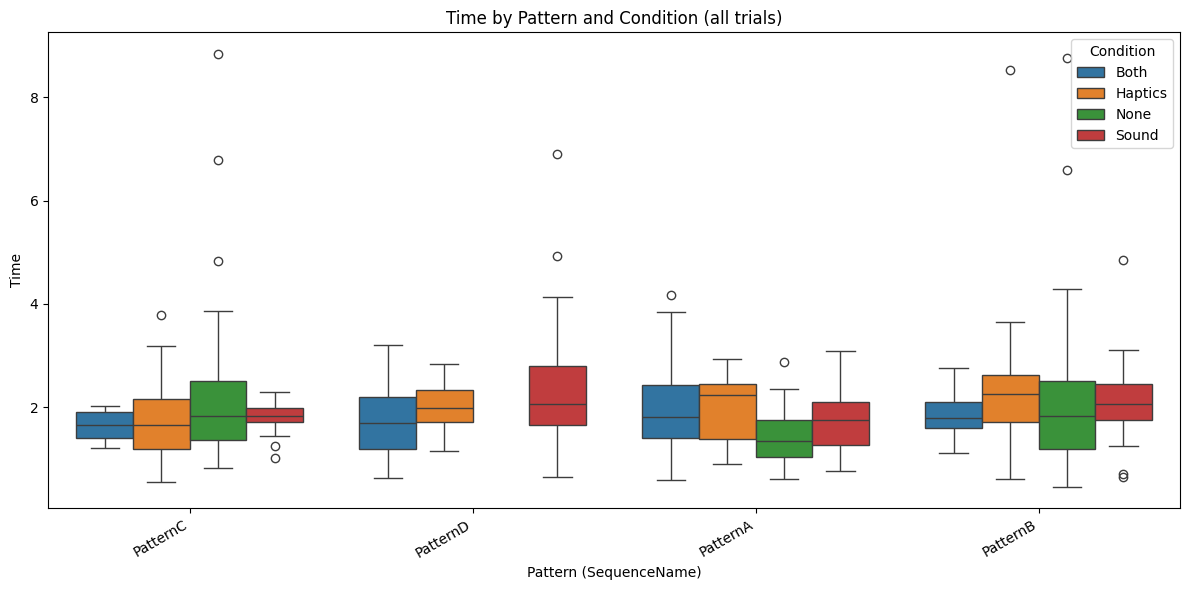

In [9]:
# Summarize and test pattern effects on Time

pattern_stats = (

    all_trials_df

    .groupby(["Condition", "SequenceName"], dropna=False)["Time"]

    .agg(mean="mean", median="median", std="std", count="count")

    .reset_index()

    .sort_values(["Condition", "mean"])

)



print("Condition x Pattern summary (mean/median/std/count):")

display(pattern_stats.round(4))



# Visualization of patterns by condition

plt.figure(figsize=(12, 6))

sns.boxplot(data=all_trials_df, x="SequenceName", y="Time", hue="Condition")

plt.title("Time by Pattern and Condition (all trials)")

plt.xlabel("Pattern (SequenceName)")

plt.ylabel("Time")

plt.xticks(rotation=30, ha="right")

plt.legend(title="Condition")

plt.tight_layout()

plt.show()
